In [2]:
import os
import gc
import time
import pickle
import kaggle
import datetime
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask import delayed, compute
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing, metrics
import lightgbm as lgb
from textblob import TextBlob

path = "F:\\Pratik\\LearningZone\\Competitions\\Avito_Demand_Prediction_Challenge\\RawData"
os.chdir(path)

C:\Program Files\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
train_df = pd.read_csv('train_translated.csv', parse_dates=['activation_date'])
test_df = pd.read_csv('test_translated.csv', parse_dates=['activation_date'])

In [3]:
total_df = pd.read_csv('total_translated_05102018.csv', parse_dates=['activation_date'])

In [ ]:
train_df['dow'] = train_df['activation_date'].dt.weekday
test_df['dow'] = test_df['activation_date'].dt.weekday

In [4]:
total_df['dow'] = total_df['activation_date'].dt.weekday

In [5]:
total_df.columns

Index(['item_id', 'user_id', 'region', 'city', 'parent_category_name',
       'category_name', 'title', 'description', 'price', 'item_seq_number',
       'activation_date', 'user_type', 'image', 'image_top_1',
       'deal_probability', 'set', 'price_new', 'en_region', 'en_city',
       'en_category_name', 'en_parent_category_name', 'en_param1', 'en_param2',
       'en_param3', 'combine_param1n2n3', 'description_num_chars',
       'description_num_words', 'description_num_unique_words',
       'description_words_vs_unique', 'combine_param1n2n3_num_chars',
       'combine_param1n2n3_num_words', 'combine_param1n2n3_num_unique_words',
       'combine_param1n2n3_words_vs_unique', 'title_num_chars',
       'title_num_words', 'title_num_unique_words', 'title_words_vs_unique',
       'dow'],
      dtype='object')

In [ ]:
# Function to extract features from them:
@delayed
def period_features(x):
    x['dow_first_day_display'] = x['date_from'].dt.weekday
    x['dow_last_day_display'] = x['date_to'].dt.weekday
    x['time_btwn_placed_display'] = (x['date_from'] - x['activation_date']).dt.days
    x['duration_display'] = (x['date_to'] - x['date_from']).dt.days
    return x

# Passing the train data through period_features fn:
periods_train = period_features(periods_train)
%time periods_train = periods_train.compute()

# Passing the test data through period_features fn:
periods_test = period_features(periods_test)
%time periods_test = periods_test.compute()

In [23]:
cat_vars = ["en_region", "en_city", "en_parent_category_name", "en_category_name", "user_type","image_top_1","en_param1","en_param2","en_param3"]

In [24]:
def label_encoding(train_data, categorical_feature_names):
    le = preprocessing.LabelEncoder() # Defining Label Encoder
    train_cat_features = np.array(train_data[categorical_feature_names])
    train_data_array = le.fit_transform(train_cat_features[:,0])
    for i in range(1,train_cat_features.shape[1]):
        train_data_array = np.column_stack((train_data_array, le.fit_transform(train_cat_features[:,i])))
        
    train_cat_data_df = pd.DataFrame(train_data_array, columns=categorical_feature_names)
    return train_cat_data_df[categorical_feature_names]

In [25]:
total_df[['en_param1','en_param2','en_param3','image_top_1']].fillna('Missing', inplace=True)

C:\Program Files\Anaconda\lib\site-packages\pandas\core\frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [ ]:
train_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)
test_df[['en_param1','en_param2','en_param3']].fillna('Missing', inplace=True)

In [26]:
total_df['en_param1'] = total_df['en_param1'].map(str)
total_df['en_param2'] = total_df['en_param2'].map(str)
total_df['en_param3'] = total_df['en_param3'].map(str)

In [ ]:
train_df['en_param1'] = train_df['en_param1'].map(str)
train_df['en_param2'] = train_df['en_param2'].map(str)
train_df['en_param3'] = train_df['en_param3'].map(str)

In [ ]:
test_df['en_param1'] = test_df['en_param1'].map(str)
test_df['en_param2'] = test_df['en_param2'].map(str)
test_df['en_param3'] = test_df['en_param3'].map(str)

In [27]:
Catg_Var_LE = label_encoding(total_df, cat_vars)

In [7]:
Catg_Var_LE_train = label_encoding(train_df,cat_vars)
Catg_Var_LE_test = label_encoding(test_df,cat_vars)

NameError: name 'train_df' is not defined

In [28]:
# Dropping the rows on which One-Hot Encoding has been performed
total_df = total_df.drop(Catg_Var_LE.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
total_df = pd.concat([total_df,Catg_Var_LE], axis=1)

In [ ]:
# Dropping the rows on which One-Hot Encoding has been performed
train_df = train_df.drop(Catg_Var_LE_train.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
train_df = pd.concat([train_df,Catg_Var_LE_train], axis=1)

In [ ]:
# Dropping the rows on which One-Hot Encoding has been performed
test_df = test_df.drop(Catg_Var_LE_test.columns, axis=1)
# Concating the rows converted using One-Hot Encoding to other columns:
test_df = pd.concat([test_df,Catg_Var_LE_test], axis=1)

In [ ]:
total_df['price_new'] = np.log(total_df['price']+0.001)
total_df["price_new"].fillna(np.nanmean(total_df["price_new"].values), inplace=True)

In [35]:
train_df = total_df[total_df['set'] == 'train']
test_df = total_df[total_df['set'] == 'test']

In [60]:
target = 'deal_probability'
predictors = ['dow', 'en_region', 'en_city',
       'en_parent_category_name', 'en_category_name', 'user_type', 'price_new', 'description_num_chars',
       'description_num_words', 'description_num_unique_words',
       'description_words_vs_unique', 'combine_param1n2n3_num_chars',
        'title_num_chars',
       'title_num_words','image_top_1','en_param1','en_param2','en_param3']

In [ ]:
['title_words_vs_unique','combine_param1n2n3_words_vs_unique','combine_param1n2n3_num_unique_words','combine_param1n2n3_num_words','title_num_unique_words']

### Standarizing data:

In [13]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

In [14]:
numeric_cols = ['price_new','description_num_chars','description_num_words','description_num_unique_words',
                'description_words_vs_unique','combine_param1n2n3_num_chars','combine_param1n2n3_num_words',
               'combine_param1n2n3_num_unique_words','combine_param1n2n3_words_vs_unique','title_num_chars',
               'title_words_vs_unique']

In [15]:
total_df[numeric_cols] = sc.fit_transform(total_df[numeric_cols])

In [ ]:
#Splitting the data for model training#
dev_X = train_df.iloc[:-200000,:]
val_X = train_df.iloc[-200000:,:]

# # Splitting based on date:
# dev_X = train_df[train_df['activation_date'] <= '2017-03-23']
# val_X = train_df[train_df['activation_date'] > '2017-03-23']

In [30]:
def run_lgb(train_X, val_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values, feature_name=predictors)
    lgval = lgb.Dataset(val_X[predictors].values, label=val_X[target].values, feature_name=predictors)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, valid_sets=[lgtrain, lgval], valid_names=['train','valid'],
                      early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    #model = lgb.cv(params, lgtrain, 5000, verbose_eval=20, nfold=5, stratified=True)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [ ]:
params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }

In [ ]:
num_leaves = [20, 25, 30, 35, 40]
learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
bst_results = []
for num_lv in num_leaves:
    for lr in learning_rate:
        new_params = {"num_leaves" : num_lv, "learning_rate" : lr}
        params.update(new_params)
        lgtrain = lgb.Dataset(train_X[predictors].values, label=train_X[target].values)
        lgval = lgb.Dataset(val_X[predictors].values, label=val_X[target].values)
        evals_result = {}
        model = lgb.train(params, lgtrain, 1000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
        bst_results.append(params, )

In [ ]:
model = lgb.LGBMRegressor(objective="regression",
        metric = "rmse",
        num_leaves = 30,
        learning_rate = 0.1,
        bagging_fraction = 0.7,
        feature_fraction = 0.7,
        bagging_frequency = 5,
        bagging_seed = 2018,
        verbosity = -1)

In [ ]:
params_opt = {'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2], "num_leaves" : [20, 25, 30, 35, 40]}

In [ ]:
gridSearchCV = GridSearchCV(estimator = model, 
    param_grid = params_opt, verbose=1)

In [ ]:
gridSearchCV.fit(train_df[predictors],train_df[target])

In [ ]:
gridSearchCV.grid_scores_

In [31]:
from sklearn.model_selection import KFold

In [32]:
kf = KFold(n_splits=5)

In [33]:
gc.collect()

0

In [61]:
columns = ['fold','train_score','valid_score']
final_stats = pd.DataFrame(columns=columns)
train_data = pd.DataFrame()
val_data = pd.DataFrame()
n=1
for train_index, val_index in kf.split(train_df):
    train_data, val_data = train_df.loc[train_index], train_df.loc[val_index]
    #y_train, y_test = y[train_index], y[val_index]
    kfold = str(n)+'_fold'
    print("Modeling for {}".format(kfold))
    model, result = run_lgb(train_data, val_data)
    results = {'fold'       : kfold,
               'train_score': result['train']['rmse'][model.best_iteration],
               'valid_score': result['valid']['rmse'][model.best_iteration]       
        }
    final_stats = final_stats.append(results, ignore_index=True)
    print("Done modeling...")
    print("Generating predictions....")
    test_df[kfold+'_predictions'] = model.predict(test_df[predictors], num_iteration=model.best_iteration)
    n=n+1

Modeling for 1_fold
Training until validation scores don't improve for 100 rounds.
[20]	train's rmse: 0.23521	valid's rmse: 0.235455
[40]	train's rmse: 0.232575	valid's rmse: 0.233007
[60]	train's rmse: 0.231395	valid's rmse: 0.231919
[80]	train's rmse: 0.23057	valid's rmse: 0.231213
[100]	train's rmse: 0.229969	valid's rmse: 0.230723
[120]	train's rmse: 0.229551	valid's rmse: 0.230406
[140]	train's rmse: 0.229185	valid's rmse: 0.23018
[160]	train's rmse: 0.228796	valid's rmse: 0.229937
[180]	train's rmse: 0.228506	valid's rmse: 0.229773
[200]	train's rmse: 0.228226	valid's rmse: 0.229609
[220]	train's rmse: 0.227975	valid's rmse: 0.229487
[240]	train's rmse: 0.227701	valid's rmse: 0.229345
[260]	train's rmse: 0.227477	valid's rmse: 0.229257
[280]	train's rmse: 0.22727	valid's rmse: 0.229194
[300]	train's rmse: 0.227032	valid's rmse: 0.229097
[320]	train's rmse: 0.22681	valid's rmse: 0.228995
[340]	train's rmse: 0.226615	valid's rmse: 0.228911
[360]	train's rmse: 0.226425	valid's rmse:

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Modeling for 2_fold
Training until validation scores don't improve for 100 rounds.
[20]	train's rmse: 0.235209	valid's rmse: 0.235239
[40]	train's rmse: 0.232533	valid's rmse: 0.232869
[60]	train's rmse: 0.231413	valid's rmse: 0.23193
[80]	train's rmse: 0.230648	valid's rmse: 0.231283
[100]	train's rmse: 0.230154	valid's rmse: 0.230922
[120]	train's rmse: 0.229643	valid's rmse: 0.23053
[140]	train's rmse: 0.229282	valid's rmse: 0.230296
[160]	train's rmse: 0.228951	valid's rmse: 0.230086
[180]	train's rmse: 0.228582	valid's rmse: 0.229837
[200]	train's rmse: 0.228348	valid's rmse: 0.229726
[220]	train's rmse: 0.228081	valid's rmse: 0.229578
[240]	train's rmse: 0.227791	valid's rmse: 0.229434
[260]	train's rmse: 0.227556	valid's rmse: 0.229299
[280]	train's rmse: 0.227367	valid's rmse: 0.229223
[300]	train's rmse: 0.22715	valid's rmse: 0.22912
[320]	train's rmse: 0.226933	valid's rmse: 0.22904
[340]	train's rmse: 0.226715	valid's rmse: 0.228953
[360]	train's rmse: 0.226525	valid's rmse:

In [62]:
final_stats

,fold,train_score,valid_score
0,1_fold,0.212518,0.227240
1,2_fold,0.214631,0.227074
2,3_fold,0.215734,0.226826
3,4_fold,0.214861,0.227031
4,5_fold,0.211511,0.226899


In [65]:
final_stats.to_csv("../Results/Stats_5foldcv_clipvalue_removingsomefeats_05112018.csv", index=False)

In [80]:
np.average(final_stats['train_score'])

0.2138507028035094

In [81]:
np.average(final_stats['valid_score'])

0.22701400996710933

In [68]:
test_df['deal_probability'] = np.average(test_df[['1_fold_predictions','2_fold_predictions','3_fold_predictions','4_fold_predictions','5_fold_predictions']], axis=1)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
test_df['deal_probability'] = np.clip(np.array(test_df['deal_probability']),0,1)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [76]:
test_df.deal_probability[test_df['deal_probability'] < 0]

Series([], Name: deal_probability, dtype: float64)

In [25]:
test_df.deal_probability[test_df['deal_probability'] < 0] = abs(test_df.deal_probability[test_df['deal_probability'] < 0])

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Program Files\Anaconda\lib\site-packages\pandas\core\generic.py:5984: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Program Files\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2910: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns

In [44]:
gc.collect()

10

In [ ]:
model, result = run_lgb(dev_X, val_X)

### Defining entire model:

In [ ]:
params = {'max_depth' : -1,
          'objective': 'regression', 
          'num_leaves': 40, 
          'learning_rate': 0.1, 
          'bagging_fraction': 1, 
          'bagging_freq': 1, 
          'feature_fraction': 0.8, 
          'metric' : 'rmse'}

In [ ]:
# Create parameters to search
gridParams = {
    'learning_rate': [0.005, 0.01, 0.05, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [35,40,45,50],
    'boosting_type' : ['gbdt'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'bagging_fraction' : [0.7,0.75],
    #'reg_alpha' : [1,1.2],
    #'reg_lambda' : [1,1.2,1.4],
    }

In [ ]:
model = lgb.LGBMRegressor(objective="regression",
        metric = "rmse",
        num_leaves = 40,
        learning_rate = 0.1,
        bagging_fraction = 1,
        feature_fraction = 0.8,
        bagging_freq = 1,
        bagging_seed = 2018,
        verbosity = -1)

In [ ]:
grid = GridSearchCV(model, gridParams, verbose=1, cv=5, n_jobs=-1)

In [ ]:
grid.fit(train_df[predictors],train_df[target])

In [ ]:
params.update(grid.best_params_)

In [ ]:
test_df['deal_probability'] = grid.predict(test_df[predictors])

In [ ]:
grid.best_params_

In [ ]:
pd.DataFrame(grid.cv_results_)

In [ ]:
test_df['deal_probability'] = model.predict(test_df[predictors])

In [ ]:
test_df.deal_probability[test_df['deal_probability'] < 0] = 0

In [77]:
test_df[['item_id','deal_probability']].to_csv('../Results/5foldcv_clipvalue_removingsomefeats_05112018.csv', index=False)

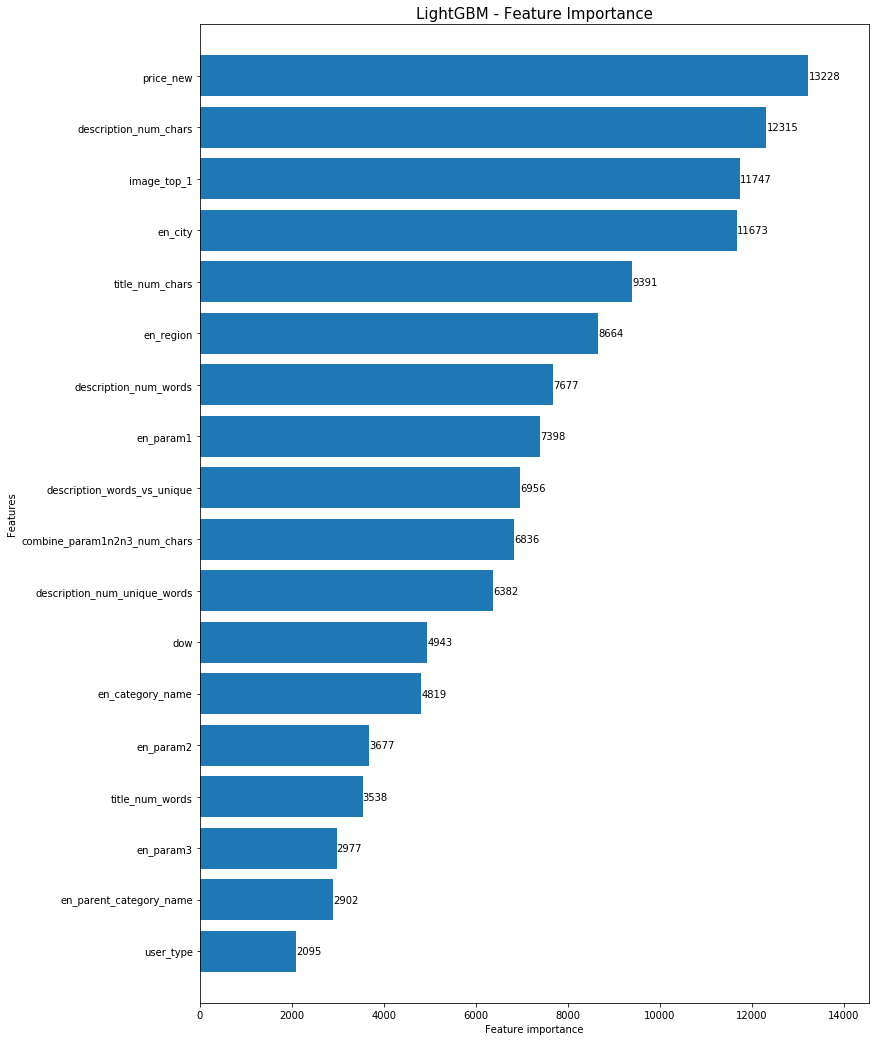

In [78]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
#lgb.plot_importance(model)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

### Running XGBoost:

In [ ]:
import xgboost as xgb

In [ ]:
len(val_X)

In [ ]:
len(dev_X)

In [ ]:
train_dmatrix = xgb.DMatrix(dev_X[predictors],dev_X[target])
valid_dmatrix = xgb.DMatrix(val_X[predictors],val_X[target])

In [ ]:
def run_xgb(train_dmatrix, valid_dmatrix):
    params = {
        "objective" : "reg:linear",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    evals_result = {}
    evallist = [(train_dmatrix,'train'), (valid_dmatrix, 'eval')]
    model = xgb.train(params, train_dmatrix, 5000, evallist, early_stopping_rounds=100, verbose_eval=20, evals_result=evals_result)
    
    #pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result

In [ ]:
model, result = run_xgb(train_dmatrix, valid_dmatrix)

In [ ]:
test_dmatrix = xgb.DMatrix(test_df[predictors])

In [ ]:
preds = model.predict(test_dmatrix)

In [ ]:
test_df['deal_probability'] = preds

In [ ]:
test_df.deal_probability[test_df['deal_probability'] < 0] = 0

In [ ]:
test_df[['item_id','deal_probability']].to_csv('base_submission_xgb_05072018.csv', index=False)

### Submission to kaggle via API:

In [79]:
!kaggle competitions submit -c avito-demand-prediction -f ../Results/5foldcv_clipvalue_removingsomefeats_05112018.csv -m "5CV removingsomefeats clipping to unit interval"

Successfully submitted to Avito Demand Prediction Challenge


In [ ]:
!kaggle competitions submit -c avito-demand-prediction -f Results/base_submission_xgb_05072018.csv -m "base submission xgb model"